# Instructions  

## Objective
  By following this set of instructions and using the provided 'skeleton' for the code, you should get a working Intelligent driver model to a 1D ring motorway. This implementation provide a basic model (including speed detection) which you may want to extend further.
  
##  Before starting
  Before starting, make sure:
  *  you are familiar with the content of the [relevant Canvas pages](https://canvas.qub.ac.uk/courses/20095/modules/151927)
  * you read Ch. 11 of "Traffic Flow Dynamics: Data, Models and Simulation" by M. Treiber and A. Kesting which describes the model ([PDF of the chapter available at this link](http://www.traffic-flow-dynamics.org/res/SampleChapter11.pdf)).     

  
## Steps

To implement the Intelligent Driver Model with detection:

  1. Define the main functions
  2. Set up the parameters and the main loop
  3. Run the simulation(s)

### Define the main functions

The notebook will involve a fair number of different routines. It is thus important to keep careful track of the routines, and you may want to sketch out what different functions are involved at what stage of the calculation.

Large parts of the code are already filled in for you, so that for the initial stages you do not need to be concerned with input and output data coming from the routines. Please do not alter these aspects if not needed.

The approach of the code is that
(a) we calculate the new positions and velocities of the cars
(b) we carry out any analysis that may involve knowledge of both starting and end positions of the cars during the step
(c) we update the positions and velocities for the next step.

### Function 1: Calculate acceleration / new position and velocity

This routine will return, for each car, the new position and velocity at the end of the time step as well as the acceleration.

You will need to insert the code needed to do this.

In [1]:
import numpy as np
# Handle case where acceleration is 0?
# Do we want to graph in mph or kmph or m/s
#########################################################################
#      1. UPD_POS_VEL
#########################################################################
def upd_pos_vel(Ncar, pos, vel, acc, headway, dv, posnew, velnew, params):
  """For each car, calculates the acceleration and the resulting position and velocity at the end of the step.

  I/O arguments:
    Following are arrays:
    Ncar    = number of cars
    pos     = car's position
    vel     = car's velocity
    acc     = car's acceleration
    headway = headway (see exact definition in book/Canvas) #distance
    dv      = velocity difference wrt preceeding car (see exact definition in book/Canvas)
    posnew  = car's new position
    velnew  = car's new velocity
    params  = list including key parameters
  """
  des_speed_inv = params[0]
  acc_exp       = params[1]
  time_gap      = params[2]
  comf_decel    = params[3]
  min_gap       = params[4]
  acc_max       = params[5]
  del_t         = params[6]

#determine acceleration for cars
  for i in range(Ncar):

    ## restricted speed zone code
    # if pos[i] > 400 and pos[i] < 600:
    #   splim = 20*1609.344/3600
    #   des_speed_inv = 1/splim

    star = min_gap + max(0,vel[i]*time_gap+(vel[i]*dv[i])/((4*acc_max*comf_decel)**0.5))
    acc[i] = acc_max*(1-(vel[i]*des_speed_inv)**acc_exp-((star)/headway[i])**2)

# Calculate new position and velocity
  for i in range(Ncar):
    # Positive velocity? Update eqns if not
    velnew[i] = vel[i] + acc[i]*del_t
    if velnew[i] < 0:
        del_t_star = -1*vel[i]/acc[i]
        posnew[i] = pos[i] + vel[i]*del_t_star + 0.5*acc[i]*del_t_star**2
        velnew[i] = vel[i] + acc[i]*del_t_star
    else:
      posnew[i] = pos[i] + vel[i]*del_t + 0.5*acc[i]*del_t**2

  return posnew, velnew, acc

### Function 2: Generate data, as obtained by a car detection loop - not needed initially

Note: this routine will not be needed initially

This routine checks for each car whether it has passed the detection loop, and, if so, returns both the velocity of the car and the time when it passes the detection point.

You will need to add code to determine whether a car has passed the detection point, and, if so, obtain its velocity. The time at which this happens should also be recorded.

In [2]:
#########################################################################
#      2. DETECT_LOOP
#########################################################################
def detect_loop(Ncar,pos,vel,acc,posnew,velnew,detect_time,detect_vel,det_point,time_pass):
  """ Simulates a speed detector.
   Check when a car passes a detection point and returns the detection time and velocity


 I/O arguments:
    Ncar = number of cars
    pos = car's position
    vel = car's velocity
    acc = car's acceleration
    posnew = car's new position
    velnew = car's new velocity
    detect_time = detection time
    detect_vel = detection velocity
    det_point = detection point
    time_pass = time passed from start of simulation
"""
# For all cars

  for i in range(Ncar):
    if (pos[i] <= det_point and det_point < posnew[i]):
      det_dist = det_point-pos[i]
      detect_vel[i] = np.sqrt((vel[i]**2)+2*acc[i]*(det_dist))
      detect_time[i] = time_pass - ((2*det_dist)/(detect_vel[i]+velnew[i]))

  return detect_time, detect_vel

### Function 3: Calculate global flow / density within each step

This routine will return the global flow and density at each time step.

You will need to insert the code to do this.

In [3]:
# Calculates global flow and global density
#########################################################################
#     4. FLOW_GLOBAL
#########################################################################
def flow_global(Ncar,velnew,road_l):

  """   Calculate the flow, determined in cars / hour and the
    density, determined in cars / km

    I/O arguments:
    Ncar    = number of cars
    vel     = car's velocity
    road_l  = length of the road
    dens    = density
    flow    = flow
  """
  dens = Ncar/(road_l/1000)
  flow = 0
  for i in range(Ncar):
    flow += (velnew[i]/(road_l))*3600 # Should we multiply by Ncar?

  return dens, flow

### Function 4: Update car data needed for next simulation step.

Once all the important data has been obtained, it is time to prepare the system for the next iteration: the position and velocity of each car needs to be updated.

With the changes to position and velocity for each car, it is also necessary to update the headway for each car and the speed differential to the car in front.

You will need to add the code to achieve this.

In [4]:
#########################################################################
#      3. UPDATE_CARS
#########################################################################
def update_cars(Ncar, pos, vel, posnew, velnew, headway, dv, params):
  """   For each car, update the position and velocity

  I/O arguments:
    Ncar = number of cars
    pos = car's position
    vel = car's velocity
    acc = car's acceleration
    headway = headway
    dv = velocity differential wrt preceeding car
    posnew = car's new position
    velnew = car's new velocity
    params = list including key parameters
  """

# Extract the key parameters
  min_gap = params[4]
  length  = params[7]
  L       = params[8]

# Updating position and velocity
  for i in range(Ncar):
    pos[i] = posnew[i] % L
    vel[i] = velnew[i]

  # Updating headway and speed differential, dv
  for i in range(Ncar):
    headway[i] = (pos[i-1] - pos[i] - length) % L
    dv[i] = vel[i] - vel[i-1]

  # check that safety margins are maintained
  for i in range(Ncar):
    if (headway[i]) < min_gap*0.5:
      print('minimum gap length drastically broken')

  return pos, vel, headway, dv

### Function 5. Single-step propagation of the IDM model

This routine calls all the functions required to propagate the model for a single time step and calls the function to determine the global flow.

It will need to be modified only when a local detection loop is being implemented.

In [5]:
def Step(N,pos,vel,headway,dv,params,time_pass,time_measure):
  # initialise
  posnew      = np.zeros(N)
  velnew      = np.zeros(N)
  acc         = np.zeros(N)
  detect_time = np.zeros(N)
  detect_vel  = np.zeros(N)
  detected = False
  # Determine the position, velocity at end of interval and acceleration at start
  posnew, velnew, acc = upd_pos_vel(N, pos, vel, acc, headway, dv, posnew, velnew, params)

  # Activate the detection loop
  if time_pass > time_measure:
    detect_time, detect_vel = detect_loop(N, pos, vel, acc, posnew, velnew, detect_time, detect_vel, det_point, time_pass)
    dens, flo = flow_global(N,velnew,L)
    detected = True

  #update the key parameters needed, after detection is complete
  pos, vel, headway, dv = update_cars(N, pos, vel, posnew, velnew, headway, dv, params)

  if detected:
    return pos, vel, headway, dv, dens, flo, detect_time, detect_vel
  else:
    return pos, vel, headway, dv

### Function 6: Set up of the overall system and model parameters

The two boxes below are for set-up of the model parameters. You need to provide the values for the model, which can be taken from the resources provided.

The parameters are separated into 2 distinct groups and associated boxes.

1. The first one is used to define parameters for the system that we want to simulate. This includes road length, density, and simulation duration.

2. The second one is used to define parameters that apply to the intelligent driver model.

In [6]:
#These parameters are not associated with the IDM approach itself
def init_params(Nmax):
# Model parameters
  Nmax          = 100                        # maximum number of cars
  L             = 1000                       # length of ring road
  steps         = 5000                      # total number of steps
  steps_measure = 1000                      # steps before we start to measure
  #splim         = 70*1609.344/3600          # speedlimit for motorway, m/s
  splim         = 30*1609.344/3600         # speedlimit for city, m/s
  det_point     =  500                      # location of a detection point - not needed initially

# In case of a detection loop add det_point to the end of params in params_setup
  params = params_setup(splim,L)
  return Nmax, L, steps, steps_measure, splim, params, det_point

The params_setup function is used to define the parameters associated directly with the model.

In [7]:
def params_setup(splim,L):
  # key parameters
  des_speed     = splim          # Desired speed
  des_speed_inv = 1./splim       # Multiplication is faster than division
  del_t         = 0.5            # Time step in seconds
  acc_exp       = 4              # Acceleration exponent
  time_gap      = 1              # Time gap in seconds
  min_gap       = 2              # Spatial gap in meters
  comf_decel    = 1.5            # Braking parameter in m/s2
  acc_max       = 1              # Maximum acceleration in m/s2
  car_length    = 5              # Car length in m

  #Params list set-up
  params=[]
  params.append(des_speed_inv)  # 0
  params.append(acc_exp)        # 1
  params.append(time_gap)       # 2
  params.append(comf_decel)     # 3
  params.append(min_gap)        # 4
  params.append(acc_max)        # 5
  params.append(del_t)          # 6
  params.append(car_length)     # 7
  params.append(L)              # 8
  return params

### Function 7: initialise the data required for a single full IDM run

We need initial velocities and positions for all of the cars. The simplest starting position is a queue of stationary cars, all spaced by the minimum distance.

It is very important NOT to start with cars equally spaced across the entire road. This starting position introduces a symmetry into the model that does not exist in real life. The equations in the model will not break the symmetry, and thus the model will not give realistic outcomes for this starting position.

So, please enter code to initialise the system.


In [8]:
def init_simulation(N,params): #added min_gap, length param to func
  min_gap    = params[4]
  car_length = params[7]
  L          = params[8]

  pos        = np.zeros(N)          # initial position
  vel        = np.zeros(N)          # initial velocity
  headway    = np.zeros(N)          # headway
  dv         = np.zeros(N)          # speed differential

  for i in range(N):
    pos[-i-1] = ((car_length + min_gap)*i) % L    # Should be able to take out mod L
  for i in range(N):
    headway[i] = (pos[i-1] - pos[i] - car_length) % L

  #print('Simulation for {0} Cars:'.format(N))

  return vel, pos, dv, headway

### Function 8: Analysis routines for use at the end of a single full IDM run

You need to define two functions here:
1. Extract key information from the global data
2. Extract key information from the local data (not needed initially)

In [9]:
def analyse_global(track_flow, track_dens):
  # Calculate global flow + density

  if len(track_flow) > 0:
    glob_flow = np.mean(track_flow)
    glob_dens = np.mean(track_dens)
  else:
    glob_flow = 0
    glob_dens = 0

  return glob_flow, glob_dens

def analyse_local(track_det_vel, track_det_flow):
# Calculate local flow + density from detection loop data

  det_num = np.zeros(len(track_det_vel[0]))
  pos_vel = np.zeros(len(track_det_vel[0]))
  track_av_vel = np.zeros(len(track_det_vel[0]))

  for i in range(len(track_det_vel)):
    for j in range(len(track_det_vel[i])):
      if track_det_vel[i][j] != track_det_vel[i-1][j] and track_det_vel[i][j] != 0:
        det_num[j] +=1
        pos_vel[j] += track_det_vel[i][j]

  for i in range(len(pos_vel)):
    track_av_vel[i] = pos_vel[i]/det_num[i]

  if len(track_det_flow) > 0:
    loc_flow = np.mean(track_det_flow)
    loc_dens = (loc_flow*1000)/(np.mean(track_av_vel)*3600)
  else:
    loc_flow = 0
    loc_dens = 0

  return loc_flow, loc_dens

### Function 9: run a single full simulation of the IDM model

This routine reads is provided with the calculation parameters and the number of cars. It then runs the simulation, and receives the global flow data for each time step.

At the end of the run, this overall data set needs to be analysed to return a specific value for the global flow and global density for this particular simulation.

Once a detection loop is set up, some modifications are needed to enable the determination of the local flow and local density. Initially, no changes should be necessary.

In [10]:
def Simulate_IDM(N,params,steps,steps_measure): # DOuble check time/step measure
  min_gap          = params[4]
  del_t            = params[6]
  length           = params[7]
  L                = params[8]
  track_det_time   = []
  track_det_vel    = []
  track_flow       = []
  track_dens       = []
  track_det_flow   = []
  detect_time      = np.zeros(N)
  vel, pos, dv, headway = init_simulation(N,params)
  for i in range(steps):
    time_pass = i * del_t
    time_measure = steps_measure * del_t
    if (time_pass > time_measure):
      prev_time = detect_time
      pos, vel, headway, dv, dens, flo, detect_time, detect_vel = Step(N,pos,vel,headway,dv,params,time_pass,time_measure)
      track_flow.append(flo)
      track_dens.append(dens)
      track_det_time.append(detect_time)
      track_det_vel.append(detect_vel)
      det_num = 0
      for j in range(N):
        if detect_time[j] != prev_time[j] and detect_vel[j] != 0:
          det_num += 1
      det_flow = (det_num*3600)/del_t
      track_det_flow.append(det_flow)
    else:
      pos, vel, headway, dv = Step(N,pos,vel,headway,dv,params,time_pass,time_measure)

  glob_flow, glob_dens = analyse_global(track_flow, track_dens)
  loc_flow, loc_dens = analyse_local(track_det_vel, track_det_flow)
  print('Simulation for {0} cars finished'.format(N))
  return glob_flow, glob_dens, loc_flow, loc_dens

### Main code: Carry out a set of IDM simulations incorporating a sweep over car numbers

This code will run the main simulation. It will carry out a sweep over car numbers. You have to provide the data for this.

You will also have to add some code to ensure that the data produced by a single run of the simulation is stored. You should also add some code to determine the average velocity from the traffic flow and traffic densities.

Finally, you should add some routines to plot the main data.

Simulation started
Simulation for 0 cars finished


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-11-5fcf0c6114f9>:34: RuntimeWarning: invalid value encountered in divide
  glob_av_vel = np.array(glob_flow) / np.array(glob_dens)


Simulation for 2 cars finished
Simulation for 4 cars finished
Simulation for 6 cars finished
Simulation for 8 cars finished
Simulation for 10 cars finished
Simulation for 12 cars finished
Simulation for 14 cars finished
Simulation for 16 cars finished
Simulation for 18 cars finished
Simulation for 20 cars finished
Simulation for 22 cars finished
Simulation for 24 cars finished
Simulation for 26 cars finished
Simulation for 28 cars finished
Simulation for 30 cars finished
Simulation for 32 cars finished
Simulation for 34 cars finished
Simulation for 36 cars finished
Simulation for 38 cars finished
Simulation for 40 cars finished
Simulation for 42 cars finished
Simulation for 44 cars finished
Simulation for 46 cars finished
Simulation for 48 cars finished
Simulation for 50 cars finished
Simulation for 52 cars finished
Simulation for 54 cars finished
Simulation for 56 cars finished
Simulation for 58 cars finished
Simulation for 60 cars finished
Simulation for 62 cars finished
Simulation f

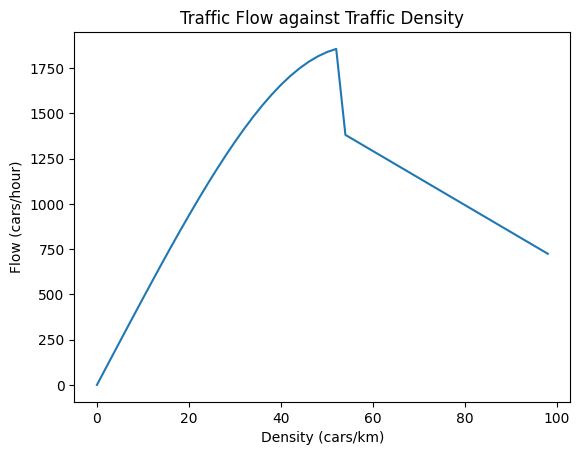

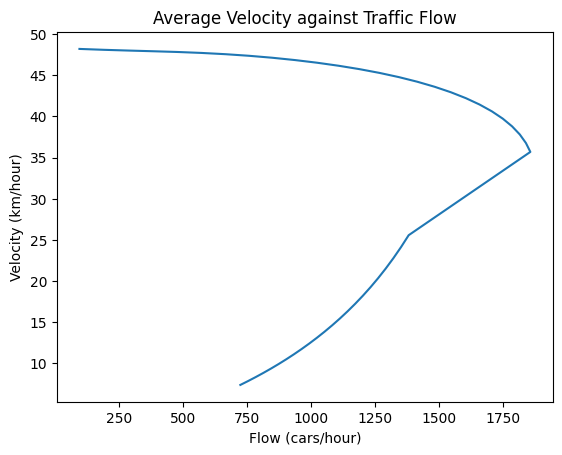

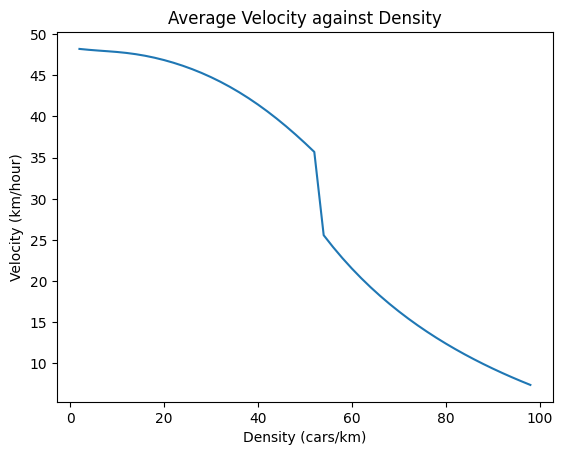

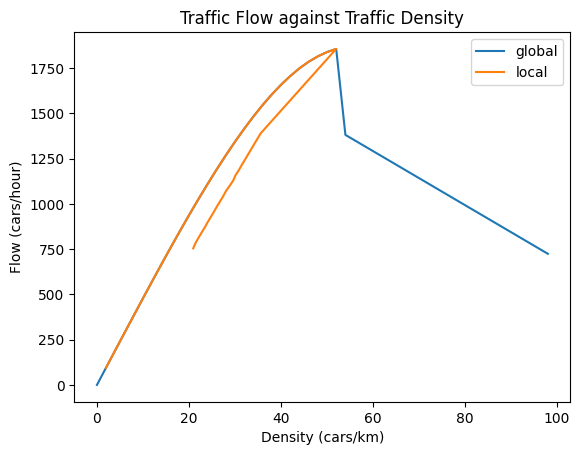

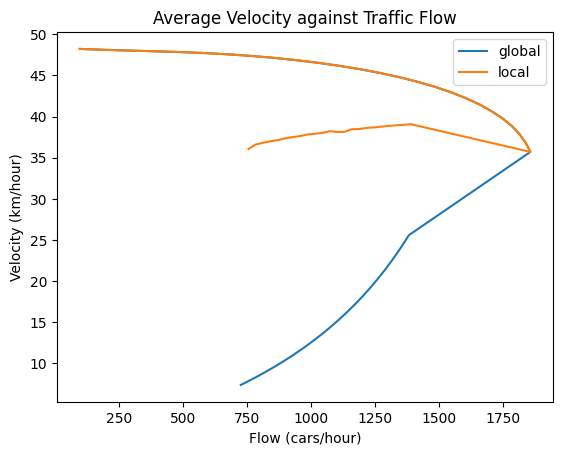

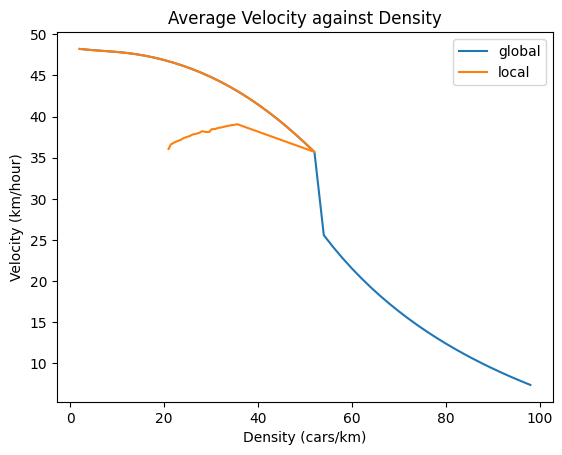

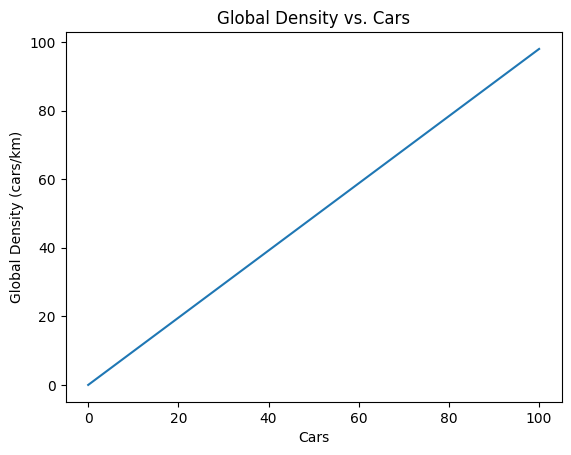

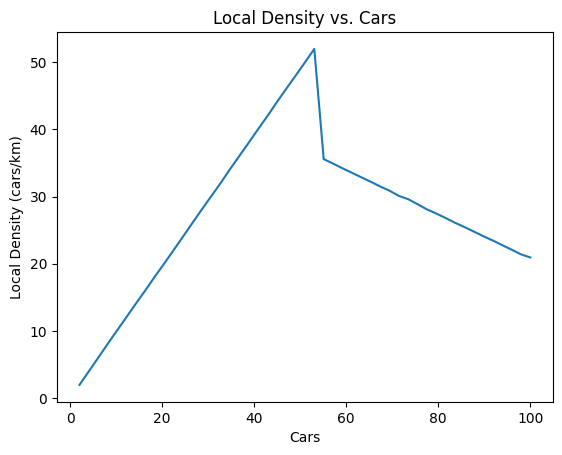

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# parameters for the sweep

start_cars = 0
end_cars   = 100
step_cars  = 2

# set up model parameters and road parameters

Nmax, L, steps, steps_measure, splim, params, det_point = init_params(end_cars)

# data needs retaining for each number of cars in the sweep

global_flow   = []
local_flow    = []
global_dens   = []
local_dens    = []
global_av_vel = []
local_av_vel  = []

print('Simulation started')
for N in range(start_cars, end_cars, step_cars):
  #glob_flow, glob_dens = Simulate_IDM(N,params,steps,steps_measure)
  glob_flow, glob_dens, loc_flow, loc_dens = Simulate_IDM(N,params,steps,steps_measure)

  global_flow.append(glob_flow)
  global_dens.append(glob_dens)
  local_flow.append(loc_flow)
  local_dens.append(loc_dens)

  glob_av_vel = np.array(glob_flow) / np.array(glob_dens)
  global_av_vel.append(glob_av_vel)
  loc_av_vel = np.array(loc_flow) / np.array(loc_dens)
  local_av_vel.append(loc_av_vel)

print('Simulations for maximum {0} cars finished'.format(end_cars))


# Plotting global data

# Flow vs. Density
plt.figure()
plt.plot(global_dens, global_flow)
plt.xlabel('Density (cars/km)')
plt.ylabel('Flow (cars/hour)')
plt.title('Traffic Flow against Traffic Density')
plt.savefig('global_flow_density.pdf')

# Velocity vs. Flow
plt.figure()
plt.plot(global_flow, global_av_vel)
plt.xlabel('Flow (cars/hour)')
plt.ylabel('Velocity (km/hour)')
plt.title('Average Velocity against Traffic Flow')
plt.savefig('global_velocity_flow.pdf')

# Velocity vs. Density
plt.figure()
plt.plot(global_dens, global_av_vel)
plt.xlabel('Density (cars/km)')
plt.ylabel('Velocity (km/hour)')
plt.title('Average Velocity against Density')
plt.savefig('global_velocity_density.pdf')


# Flow vs. Density
plt.figure()
plt.plot(global_dens, global_flow, label='global')
plt.plot(local_dens, local_flow, label='local')
plt.xlabel('Density (cars/km)')
plt.ylabel('Flow (cars/hour)')
plt.title('Traffic Flow against Traffic Density')
plt.legend()
plt.savefig('local_flow_density.pdf')

# Velocity vs. Flow
plt.figure()
plt.plot(global_flow, global_av_vel, label='global')
plt.plot(local_flow, local_av_vel, label='local')
plt.xlabel('Flow (cars/hour)')
plt.ylabel('Velocity (km/hour)')
plt.title('Average Velocity against Traffic Flow')
plt.legend()
plt.savefig('local_velocity_flow.pdf')

# Velocity vs. Density
plt.figure()
plt.plot(global_dens, global_av_vel, label='global')
plt.plot(local_dens, local_av_vel, label='local')
plt.xlabel('Density (cars/km)')
plt.ylabel('Velocity (km/hour)')
plt.title('Average Velocity against Density')
plt.legend()
plt.savefig('local_velocity_density.pdf')


##examining the difference in local and global density


N1 = np.linspace(0, 100, 50)

plt.figure()
plt.plot(N1, global_dens)
plt.xlabel('Cars')
plt.ylabel('Global Density (cars/km)')
plt.title('Global Density vs. Cars')
plt.savefig('GLOBALdensity_cars.pdf')

plt.figure()
plt.plot(N1, local_dens)
plt.xlabel('Cars')
plt.ylabel('Local Density (cars/km)')
plt.title('Local Density vs. Cars')
plt.savefig('LOCALdensity_cars.pdf')

plt.show()